In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import os 
import sys
from Backtester import Backtester
from simulator import Simulator
from utils import *
from datetime import datetime


os.chdir('/Users/yinki/OneDrive/Python/Crypto Whales')
print(os.getcwd())

Pool_address = '0xcbcdf9626bc03e24f779434178a73a0b4bad62ed' # WETH/WBTC pool 0.3% fee
simulator = Simulator(Address='0xcbcdf9626bc03e24f779434178a73a0b4bad62ed')


c:\Users\yinki\OneDrive\Python\Crypto Whales
c:\Users\yinki\OneDrive\Python\Crypto Whales
Initializing Backtester...


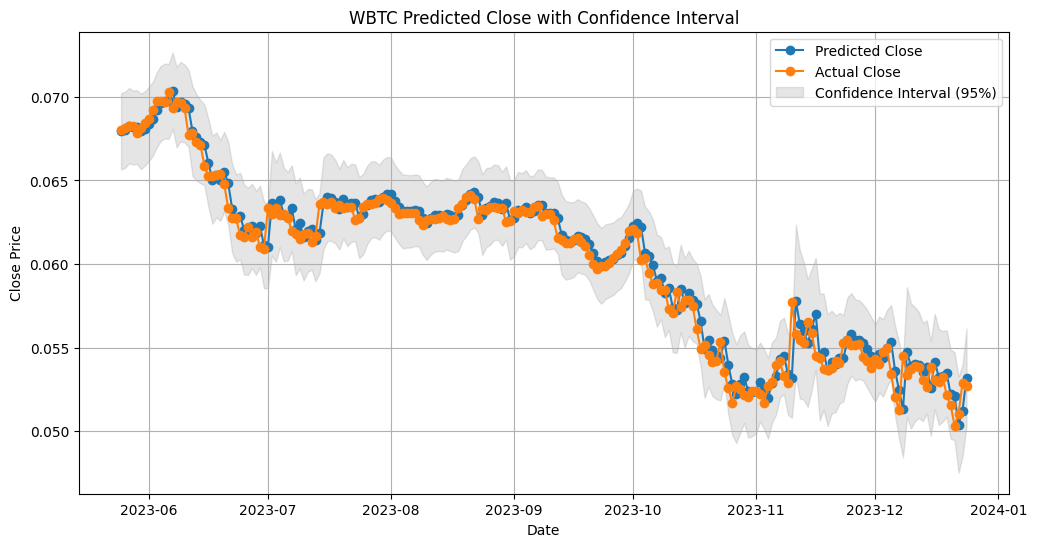

In [2]:
# Looking over our test period as well as our ARIMA-GARCH predictions

start_date = "2023-05-25"
end_date = "2023-12-24"
df = pd.read_csv('data/pools_daily_weth_btc_arima_garch.csv', index_col=0, parse_dates=True, sep=';').loc['2023-05-25':'2023-12-24']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Predicted Close (WBTC)'], label='Predicted Close', marker='o')
plt.plot(df.index, df['Close (WBTC)'], label='Actual Close', marker='o')
plt.fill_between(df.index, df['Predicted Close (WBTC)'] - 1.96 * df['Conditional Volatility'], df['Predicted Close (WBTC)'] + 1.96 * df['Conditional Volatility'], color='gray', alpha=0.2, label='Confidence Interval (95%)')
plt.title('WBTC Predicted Close with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
# Simulating based on our desired parameters initial investment, number of individual windows and risk level

risk_param = 0.95
initial_investment = 1000000
windows = 3

results = simulator.simulate(windows, risk_param, initial_investment)

Total Months: 7
Test Period: 2023-05-25 to 2023-08-03
Lower Bound: 0.06078232621947019, Upper Bound: 0.07032738733401193
Initial Investment USD: 1000000, BTC-USD: 26225.4140625
Initial Amounts: 19.065475908536953 token0, 280.1827242846707 token1
Final Amounts: 5.879422303603768 token0, 473.962540708744 token1
Simulated Position returned 1.5489266329780529 in  70  days, for an APR of  8.076546014814133
Base position returned 7.925577057852086e-17 in  70  days, for an APR of  4.1326223230228737e-16
Fees in token 0 and token 1 0.2740389966695989 5.294321528422265
Total Fees in USD 24403.641220798578
Your liquidity was active for: 37.02189443323616
Final Net Liquidity Value of LP Investment (WBTC):  38.12878769631342
Total Premiums: 34817.88885724274
Fees: 24403.641220798578, Hedging Costs: 34817.88885724274, Payoff: 0
Current Value USD at end of period 2023-05-25 to 2023-08-03: 1045999.766723796 USD
HODL 50-50- Start Value: 1000000, End_Value: 1069101.3208821146
--------------------------

In [4]:
def grid_search():
    risk_param = np.arange(0.5, 1.0, 0.05)
    initial_investment = 1000000
    windows = np.arange(1, 8)
    results = pd.DataFrame(columns=['Risk Parameter', 'Initial initial_investment', 'Windows', 'cumulative_return', 'cumulative_hodl'])
    
    for risk in risk_param:
        
        for window in windows:
                result = simulator.simulate(window, risk, initial_investment)
                cum_res = result['Cumulative Investment USD'][-1]
                cum_hodl = result['HODL 50-50'][-1]
                results = results.append({'Risk Parameter': risk, 'Initial initial_investment': initial_investment, 'Windows': window, 'cumulative_return': cum_res, 'cumulative_hodl': cum_hodl}, ignore_index=True)
    return results


#grid = grid_search()
#grid = grid.sort_values(by='cumulative_return', ascending=False).reset_index(drop=True)
#grid 

Window 1
Window 2
Window 3


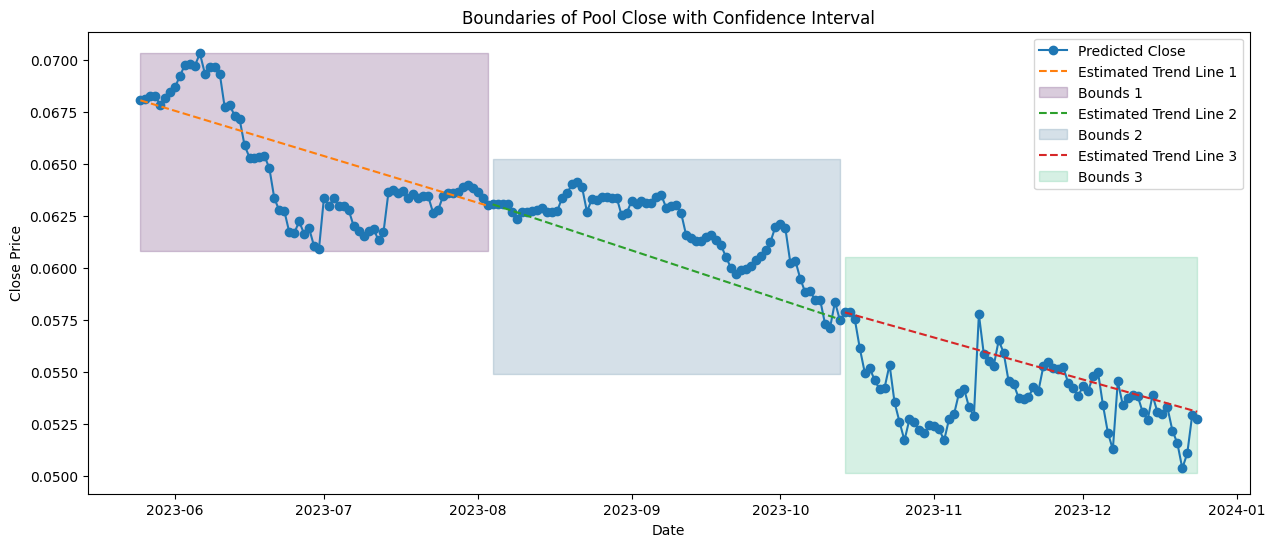

In [6]:
# Plot the windows
# Plotting
start_dates = results['Start Date']
end_dates = results['End Date']
start_prices = results['Start Price (WBTC)']
end_prices = results['End Price (WBTC)']
lower_bounds = results['Lower Bound']
upper_bounds = results['Upper Bound']
df.index = pd.to_datetime(df.index)

cmap = cm.get_cmap('viridis')

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close (WBTC)'], label='Predicted Close', marker='o')
plt.title('Boundaries of Pool Close with Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Close Price')

# Plotting each window with its boundaries
for i, (start_date, end_date, start_price, end_price, lower_bound, upper_bound) in enumerate(zip(start_dates, end_dates, start_prices, end_prices, lower_bounds, upper_bounds)):
    print(f'Window {i + 1}')
    #print(f'Start Date: {start_date}')
    #print(f'End Date: {end_date}')
    #print(f'Start Price: {start_price}')
    #print(f'End Price: {end_price}')
    window = df[(df.index >= start_date) & (df.index <= end_date)]
    #print(window)
    color = cmap(i / windows)
    # Convert DatetimeIndex to list of strings for plotting dotted line
    date_strings = [str(date) for date in window.index]

    # Plot the start and end prices as a dotted line
    plt.plot(window.index[[0, -1]], [start_price, end_price], linestyle='--', label=f'Estimated Trend Line {i + 1}')

    # Plot the lower and upper bounds
    plt.fill_between(window.index, lower_bound, upper_bound, color=color, alpha=0.2, label=f'Bounds {i + 1}')
    plt.legend()

In [7]:
window = df.loc[(df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))]
#window

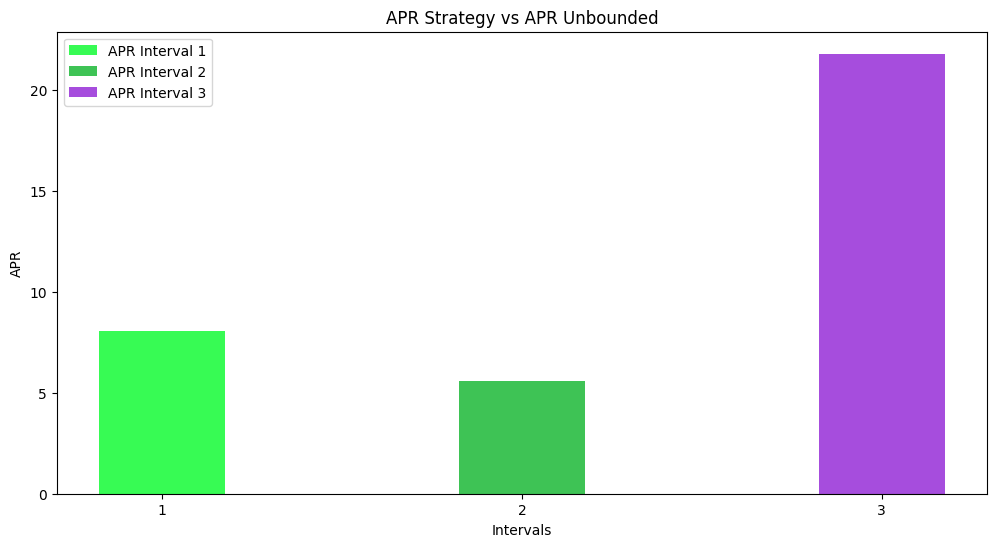

,APR Strategy,APR Unbounded
1,8.076546,4.132622e-16
2,5.610429,3.499804e-16
3,21.811494,1.506858e-15


In [9]:
results.keys()

# Plotting APR Strategy vs APR Unbounded Bar Graphs

# Generate x-axis values
intervals = np.arange(1, windows + 1)
colors = np.random.rand(len(intervals), 3)
# Plotting APR Strategy
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
bar_positions_strategy = intervals 
for i, (position, apr) in enumerate(zip(bar_positions_strategy, results['APR Strategy'])):
    ax.bar(position, apr, bar_width, label=f'APR Interval {i+1}', alpha=0.8, color=colors[i])
#ax.bar(bar_positions_unbounded, results['APR Unbounded'], bar_width, label='APR Unbounded', alpha=0.8)
ax.set_xlabel('Intervals')
ax.set_ylabel('APR')
ax.set_title('APR Strategy vs APR Unbounded')
ax.set_xticks(intervals)
ax.legend()
plt.show()

'''
# Plotting APR Unbounded
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
bar_positions_unbounded = intervals 
ax.bar(bar_positions_unbounded, results['APR Unbounded'], bar_width, label='APR Unbounded', alpha=0.8, color='orange')
ax.set_xlabel('Intervals')
ax.set_ylabel('APR')
ax.set_title('APR Strategy')
ax.set_xticks(intervals)
ax.legend()
plt.show()
'''


# Table of APRs
apr_results = pd.DataFrame({
    'APR Strategy': results['APR Strategy'],
    'APR Unbounded': results['APR Unbounded']
}, index=intervals)
apr_results

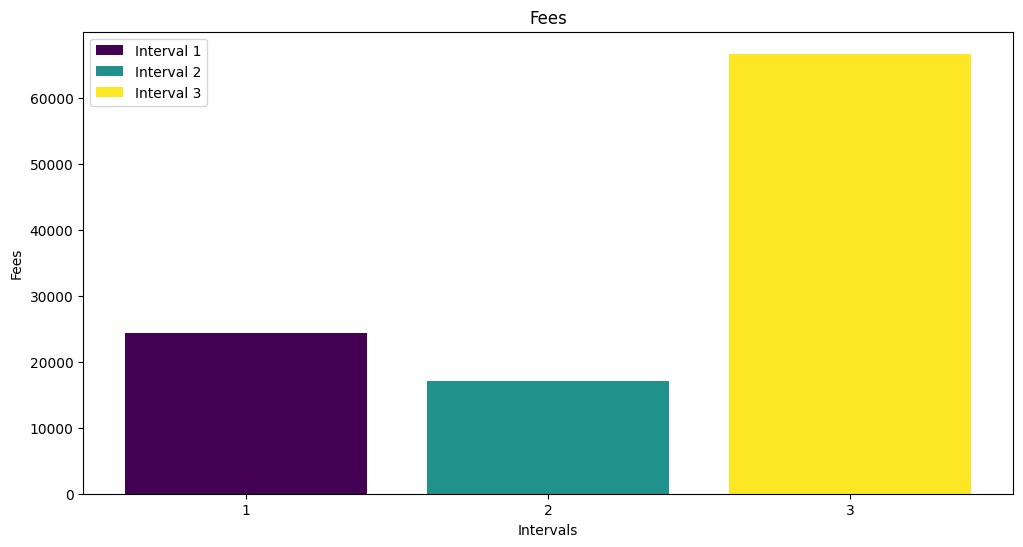

,Fees,Hedging Costs,Payoff,Gas Fees
1,24403.641221,34817.888857,0.000000,3000.0
2,17132.901803,38596.237342,0.000000,3000.0
3,66630.442070,35734.643866,27171.853381,3000.0


In [10]:

# Generate different colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(intervals)))

plt.figure(figsize=(12, 6))
# Plotting bars with different colors
for i, interval in enumerate(intervals):
    plt.bar(interval, results['Fee USD'][i], label=f'Interval {interval}', color=colors[i])

# Adding labels and title
plt.title('Fees')
plt.xlabel('Intervals')
plt.ylabel('Fees')
plt.legend()

# Setting discrete x-axis ticks
plt.xticks(intervals)
plt.show()


# Show Table of Results
fee_res = pd.DataFrame({
        'Fees': results['Fee USD'],
        'Hedging Costs': results['Hedging Costs'],
        'Payoff': results['Payoff'],
        'Gas Fees': results['Gas Fees'],
    }, index=intervals)
fee_res

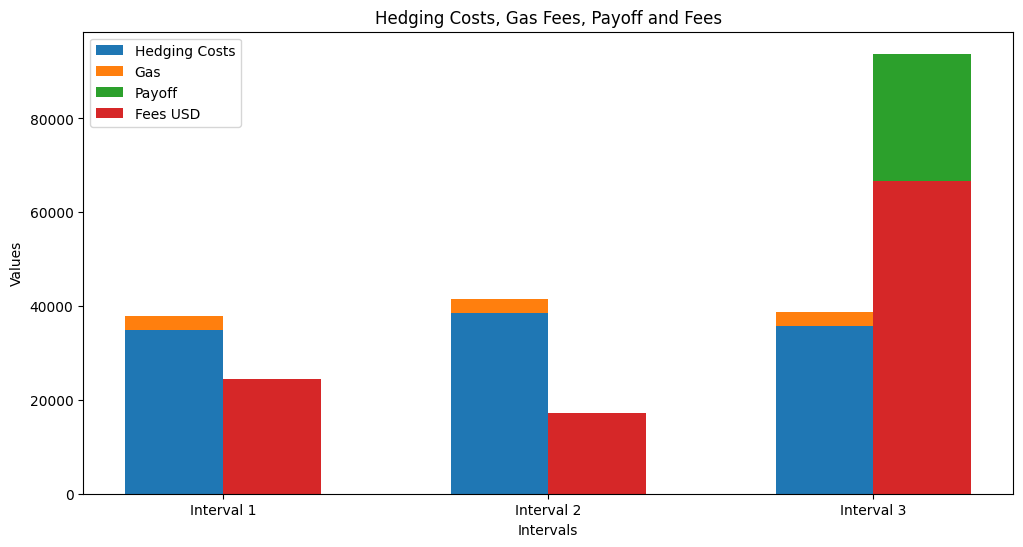

In [12]:
# Data
hedging_costs = results['Hedging Costs']
payoff = results['Payoff']
fees_usd = results['Fee USD']
gas_fees = results['Gas Fees']

# Number of sets
num_sets = len(hedging_costs)

# Set up the index for each set
index = np.arange(num_sets)

# Bar width
bar_width = 0.3

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

bar1 = ax.bar(index, hedging_costs, bar_width, label='Hedging Costs')
bar4 = ax.bar(index, gas_fees, bar_width, label='Gas', bottom=hedging_costs)
bar2 = ax.bar(index + bar_width, payoff, bar_width, label='Payoff', bottom=fees_usd)
bar3 = ax.bar(index + bar_width, fees_usd, bar_width, label='Fees USD')

# Adding labels and title
ax.set_xlabel('Intervals')
ax.set_ylabel('Values')
ax.set_title('Hedging Costs, Gas Fees, Payoff and Fees')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'Interval {i+1}' for i in range(num_sets)])
ax.legend()

plt.show()

Text(0.5, 0, 'Intervals')

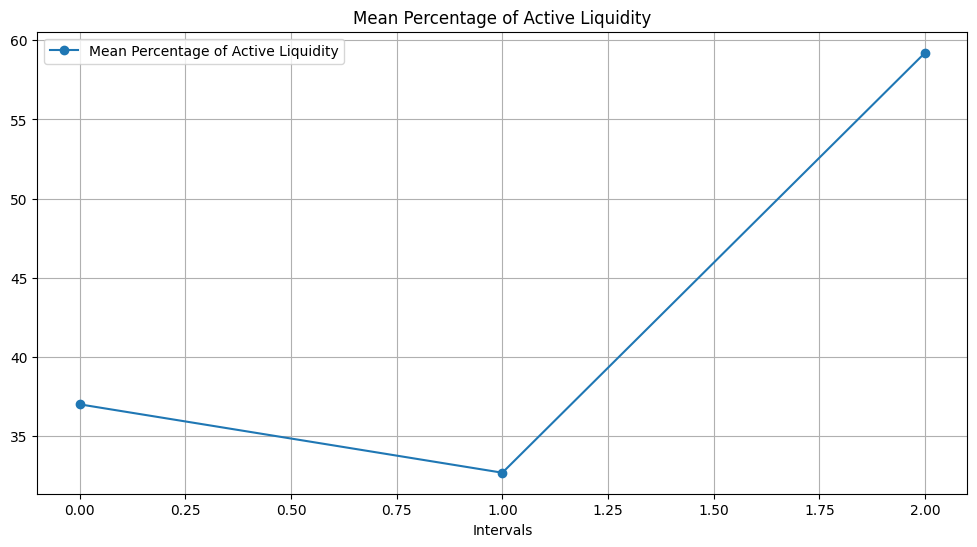

In [13]:
# Plot Mean Percentage of Active Liquidity
plt.figure(figsize=(12, 6))
plt.plot(results['Mean Percentage of Active Liquidity'], label='Mean Percentage of Active Liquidity', marker='o')
plt.title('Mean Percentage of Active Liquidity')
plt.grid(True)
plt.legend()
plt.xlabel('Intervals')


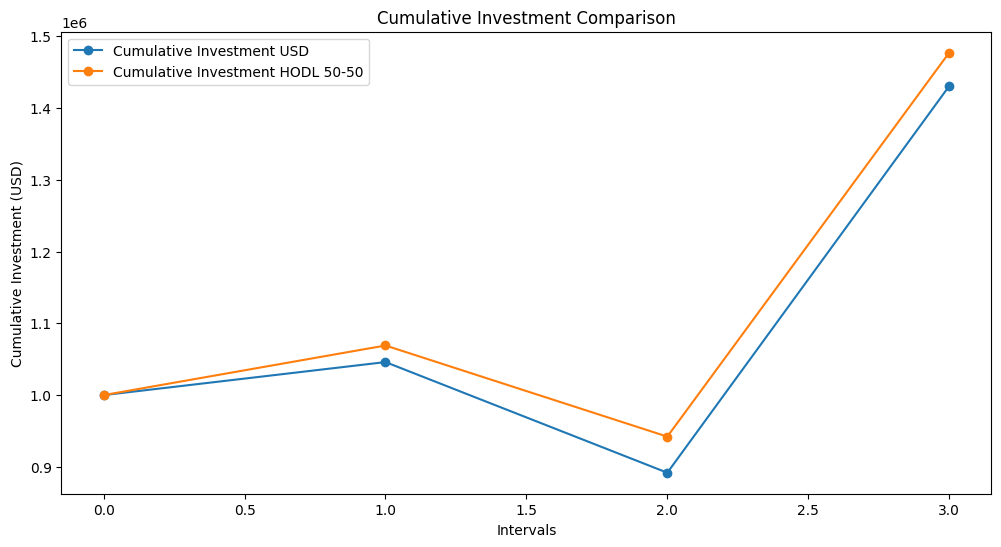

,Cumulative Investment USD,HODL 50-50,Excess Return
1,1.046000e+06,1.069101e+06,-23101.554158
2,8.918560e+05,9.421510e+05,-50294.997751
3,1.430393e+06,1.476980e+06,-46586.973160


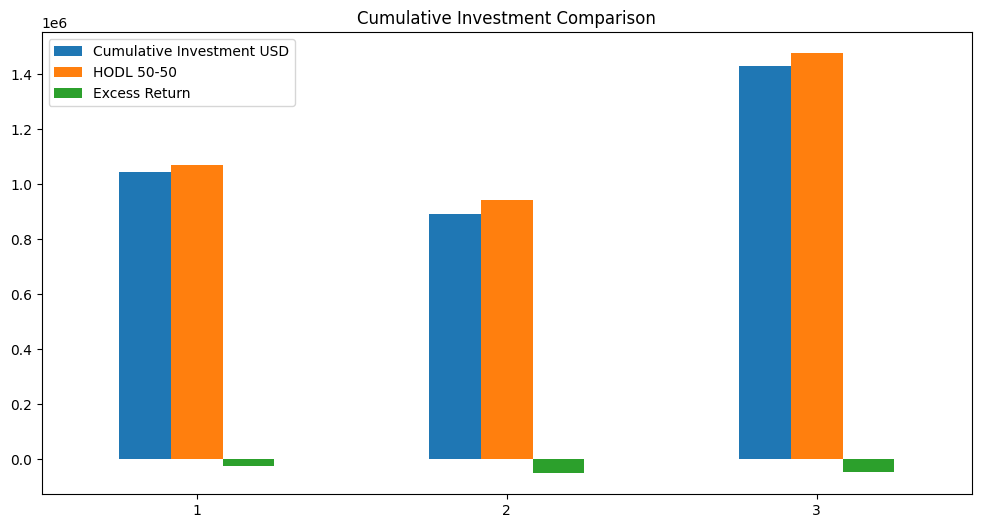

In [14]:
# Plot Cumulative Investment USD vs HODL 50-50
num_intervals = [i for i in range(0, windows + 1)]
cum_investment = [initial_investment] + results['Cumulative Investment USD']
hodl = [initial_investment] + results['HODL 50-50']
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(num_intervals, cum_investment, label='Cumulative Investment USD', marker='o')
ax.plot(num_intervals, hodl, label='Cumulative Investment HODL 50-50', marker='o')

ax.set_xlabel('Intervals')
ax.set_ylabel('Cumulative Investment (USD)')
ax.set_title('Cumulative Investment Comparison')
ax.legend()


plt.show()


# Show Table of Cumulative Investment USD vs HODL 50-50
cumulative_results = pd.DataFrame({
    'Cumulative Investment USD': results['Cumulative Investment USD'],
    'HODL 50-50': results['HODL 50-50']
}, index=intervals)
cumulative_results['Excess Return'] = (cumulative_results['Cumulative Investment USD'] - cumulative_results['HODL 50-50'])

cumulative_results.plot.bar(figsize=(12, 6), rot=0, title='Cumulative Investment Comparison')
cumulative_results

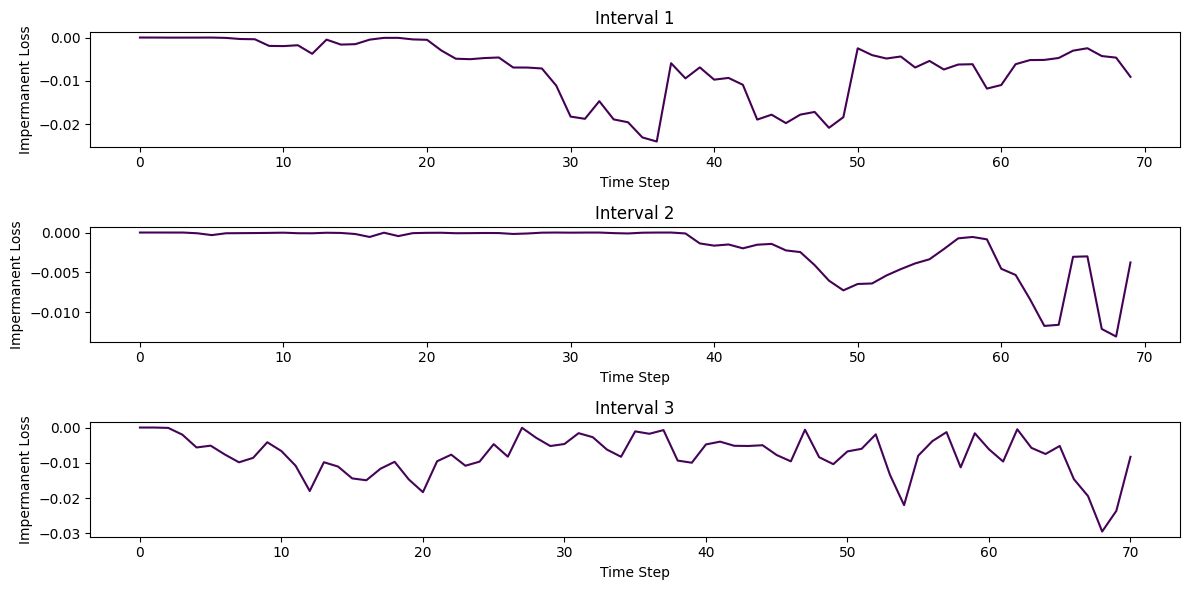

,Mean,Standard Deviation,Minimum,Maximum
1,-0.007212,0.006764,-0.023981,0.0
2,-0.002082,0.003243,-0.013066,0.0
3,-0.007842,0.005862,-0.029509,0.0


In [15]:

IL = results['Impermanent Loss']
#x_values = [i for i in range(1, windows + 1)]
x_values = [i for i in range(sum([len(i) for i in IL]))]
# Plotting
fig, axs = plt.subplots(nrows=len(IL), figsize=(12, 6))
colors = cm.viridis(range(len(IL)))

for i, (ax, data) in enumerate(zip(axs, IL)):
    ax.plot(data, color=colors[i])
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Impermanent Loss')
    ax.set_title(f'Interval {i + 1}')

plt.tight_layout()
plt.show()

IL_Statistics = []
for i in range(len(IL)):
    IL_Statistics.append([np.mean(IL[i]), np.std(IL[i]), np.min(IL[i]), np.max(IL[i])])

IL_Statistics = pd.DataFrame(IL_Statistics, columns=['Mean', 'Standard Deviation', 'Minimum', 'Maximum'], index=[i for i in range(1, windows + 1)])
IL_Statistics

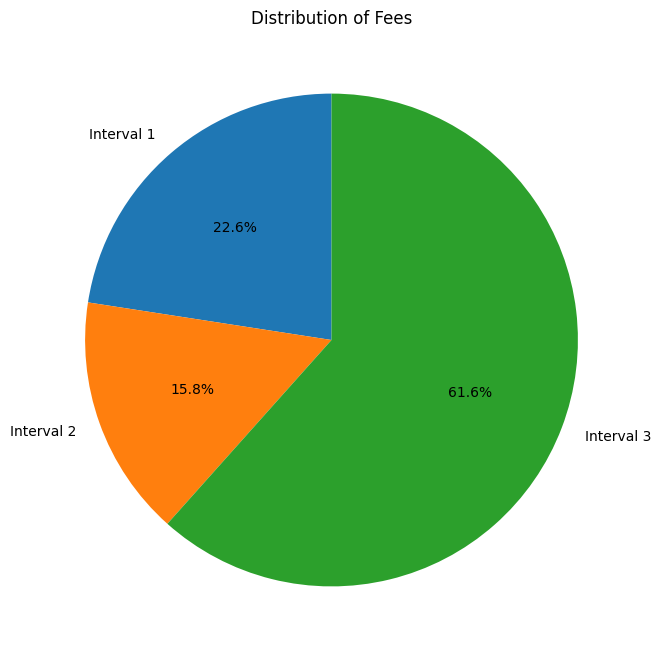

In [16]:
# Pie Chart of Fees Earned, dont really say much
fees = results['Fee USD']

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(fees, labels=[f'Interval {i+1}' for i in range(len(fees))], autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Fees')
plt.show()